In [1]:
#Setup
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [112]:
def readData(filename):
    convertfunc = lambda x: (pd.to_datetime(x,utc=True)).tz_convert('Asia/Kolkata')
    return pd.read_csv(filename,
                    names=["datetime","open","high","low","close","volume"],
                    dtype=None,
                    delimiter = ',',
                    converters = {0:convertfunc},
                  #  index_col = 0
                   )

# Making sure that 2 timeseries are synced to the smaller time series 
def sanitizeTimeSeries(ts1,ts2):
    # If TS1 is not bigger, then make TS1 the bigger one and TS2 the smaller one.
    flipped = 0
    if len(ts2) > len(ts1):
        flipped = 1
        ts1,ts2 = ts2,ts1
    for dt in ts1["DateTime"].values:
        if dt in ts2['DateTime'].values:
            continue
        else:
            #print(dt)
            ts1.drop(ts1[ts1["DateTime"]==dt].index,inplace = True)
    if flipped:
        return ts2, ts1.reset_index(drop = True)
    else:
        return ts1.reset_index(drop = True), ts2
    

#Creates Lagged series to generate 60-1 x y split    
def timeseriesLagged(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+2)] 
    df = pd.concat(columns,axis=1)
    df.fillna(0, inplace=True)
    df.columns = [str(lag+2-x) for x in range(1,lag+2)]
    df = df[df.columns[::-1]] #Flip because we want newer data on the right
    df= df.iloc[lag+1:] # drop the first 'lag' columns because zeroes.
    df.reset_index(drop=True,inplace=True)
    return df


# Binarizes the last column into 1 or 0.
# dif is the cost to buy. Rate is the per transasction cost. max is
def binarizeTime(series,lag,dif=0,rate=0.01,maxPer=[20]):
    #-1 is autocalculate the dif 
    if dif != 0:
        raise Exception("dif not yet baked in! ")
    series[str(lag+1)] = np.where(series[str(lag)] + dif < series[str(lag+1)], 1, 0)
    return series

In [113]:
# Setup Parameters
dataInit = readData("data/TRIL.csv")
data = dataInit['close'].diff().dropna() #difference the data and drop the useless rows
#data = (data-data.min())/(data.max()-data.min()) # Min max normalize
#data = data/np.linalg.norm(data) #vector norm
#data = np.log(data)
lag = 4 # 24*5 minutes
dif = 0 # difference between prices to trigger purchase for binarize
series = timeseriesLagged(data,lag)


# Turn the 61st column into or zero
#series = binarizeTime(series,lag,dif)
seriesVals = series.values

#Split into train and test
trainBegin = int(0.8*len(seriesVals))
train = seriesVals[0:trainBegin]
test = seriesVals[trainBegin:]

# Split into x and y
xTrain,yTrain = train[:,0:-1],train[:,-1] # X is the first 60 elements. Y is the 61st element
xTest,yTest = test[:,0:-1],test[:,-1]

#Reshape for keras
xTrain = xTrain.reshape((xTrain.shape[0], xTrain.shape[1], 1))
xTest = xTest.reshape(xTest.shape[0], xTest.shape[1],1)

In [123]:
xTrain.shape


(6220, 4, 1)

In [71]:
### from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import time

model = Sequential()
layers = [1, 50, 100,200,400,800,1600, 1]
model.add(LSTM(
        layers[1],
        input_shape=(None, 1),
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[2],
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[3],
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[4],
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[5],
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[6],
        return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
        layers[7]))
model.add(Activation("linear"))
start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print ("Compilation Time : " + str(time.time() - start))
model.summary()

Compilation Time : 0.009305715560913086
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
dropout_49 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_51 (LSTM)               (None, None, 100)         60400     
_________________________________________________________________
dropout_50 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_52 (LSTM)               (None, None, 200)         240800    
_________________________________________________________________
dropout_51 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 

In [72]:
epoch = 30

try:
    model.fit(
        xTrain, yTrain,
        batch_size=512, epochs=epoch, validation_split=0.10)

except KeyboardInterrupt:
    print ('Training duration (s) : ', time.time() - global_start_time)


Train on 5598 samples, validate on 622 samples
Epoch 1/30
5598/5598 [==============================] - 2s - loss: 2.5296 - val_loss: 1.6524
Epoch 2/30
5598/5598 [==============================] - 1s - loss: 2.5209 - val_loss: 1.6523

In [73]:
predicted = model.predict(xTest)
#predicted = np.reshape(predicted, (predicted.size,))

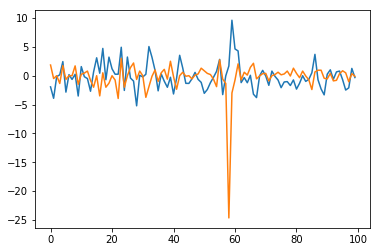

In [75]:
plt.plot(predicted[:100]*10)
plt.plot(yTest[:100])

plt.show()

In [154]:
dataInit['close'][trainBegin:].shape
xTest.shape


(1556, 4, 1)

/home/s2c/anaconda3/envs/AlgoTrading/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


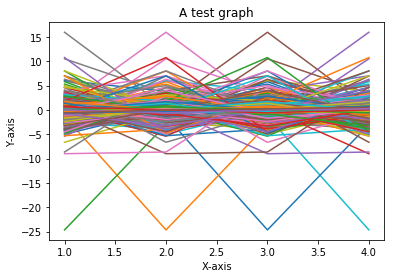

In [57]:
x = range(1,lag+1)
for i in range(0,xTest.shape[0]):
    plt.plot(x,xTest[i])
    
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("A test graph")    
plt.legend()
plt.show()

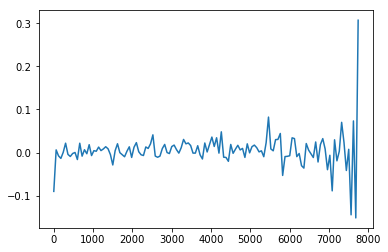

In [71]:

end = len(data)
skip = 60
#data = readData("data/A2Z.csv")
#df = data['close']
#temp = (df - df.mean()) / (df.max() - df.min())
x = range(1,end+1,skip)
plt.plot(x,[data.autocorr(i) for i in range(1,end+1,skip)])
plt.show()


In [160]:
predicted.shape

(1556, 1)

In [76]:
corr = 0
wrong = 0
total = 0
totalPreds = len(yTest)
for i in range(1,totalPreds):
    total+= 1
    if predicted[i] > predicted[i-1] and yTest[i] > yTest[i-1]:
        corr += 1      
    elif predicted[i] < predicted[i-1] and yTest[i] < predicted[i-1]:
        corr += 1
    else:
        wrong +=1

In [77]:
corr

903

In [82]:
dataInit

DateTime    open    high     low   close  volume
0    2017-01-02 09:15:00+05:30  362.00  362.00  350.25  355.75   14601
1    2017-01-02 09:20:00+05:30  355.60  355.60  353.10  353.10    3388
2    2017-01-02 09:25:00+05:30  353.10  354.00  347.35  352.65    6992
3    2017-01-02 09:30:00+05:30  352.65  353.75  351.95  352.00    1798
4    2017-01-02 09:35:00+05:30  352.00  352.75  351.45  352.75     540
5    2017-01-02 09:40:00+05:30  352.75  353.70  351.55  353.00    1711
6    2017-01-02 09:45:00+05:30  352.55  353.00  352.50  353.00     890
7    2017-01-02 09:50:00+05:30  352.55  352.55  352.05  352.50     451
8    2017-01-02 09:55:00+05:30  352.50  352.90  352.00  352.80     470
9    2017-01-02 10:00:00+05:30  352.80  352.95  352.25  352.95     738
10   2017-01-02 10:05:00+05:30  352.45  352.95  352.45  352.55      86
11   2017-01-02 10:10:00+05:30  352.55  352.85  352.00  352.05    1217
12   2017-01-02 10:15:00+05:30  352.75  352.75  352.10  352.10     125
13   2017-01-02 10:20:00+05:30  352.10  353.00  352.10  353.00     470
14   2017-01-02 10:25:00+05:30  353.00  353.90  352.50  353.90     450
15   2017-01-02 10:30:00+05:30  353.90  354.00  353.05  353.05     357
16   2017-01-02 10:35:00+05:30  353.05  353.95  353.05  353.30      89
17   2017-01-02 10:40:00+05:30  353.30  353.90  353.30  353.90      40
18   2017-01-02 10:45:00+05:30  353.90  353.90  351.50  351.80     688
19   2017-01-02 10:50:00+05:30  351.80  354.95  351.80  354.95    4844
20   2017-01-02 10:55:00+05:30  354.95  356.45  354.10  354.30    4883
21   2017-01-02 11:00:00+05:30  354.30  357.00  354.30  356.40    1510
22   2017-01-02 11:05:00+05:30  356.25  356.25  354.30  354.30    1772
23   2017-01-02 11:10:00+05:30  354.30  354.50  352.20  352.25    1242
24   2017-01-02 11:15:00+05:30  352.20  353.15  352.20  353.00     417
25   2017-01-02 11:20:00+05:30  353.00  353.00  352.35  353.00      45
26   2017-01-02 11:25:00+05:30  353.00  353.90  353.00  353.90     121
27   2017-01-02 11:30:00+05:30  353.90  353.90  353.10  353.10     100
28   2017-01-02 11:35:00+05:30  353.10  353.10  353.10  353.10       0
29   2017-01-02 11:40:00+05:30  353.10  353.85  353.10  353.85      40
...                        ...     ...     ...     ...     ...     ...
7752 2017-06-01 13:00:00+05:30  374.00  374.00  374.00  374.00       0
7753 2017-06-01 13:05:00+05:30  374.00  374.00  374.00  374.00       1
7754 2017-06-01 13:10:00+05:30  374.00  374.00  374.00  374.00      10
7755 2017-06-01 13:15:00+05:30  374.00  374.00  374.00  374.00       0
7756 2017-06-01 13:20:00+05:30  374.00  374.00  374.00  374.00     100
7757 2017-06-01 13:25:00+05:30  374.00  375.90  373.95  373.95      36
7758 2017-06-01 13:30:00+05:30  373.95  375.90  373.95  375.90      27
7759 2017-06-01 13:35:00+05:30  375.90  375.90  374.20  374.20      18
7760 2017-06-01 13:40:00+05:30  374.20  374.20  374.20  374.20       0
7761 2017-06-01 13:45:00+05:30  374.20  374.20  374.20  374.20       0
7762 2017-06-01 13:50:00+05:30  374.20  375.90  374.20  375.90      30
7763 2017-06-01 13:55:00+05:30  375.90  375.90  375.85  375.85      32
7764 2017-06-01 14:00:00+05:30  375.85  375.85  375.85  375.85       0
7765 2017-06-01 14:05:00+05:30  375.85  375.85  375.00  375.00      20
7766 2017-06-01 14:10:00+05:30  375.00  375.00  371.75  371.75     195
7767 2017-06-01 14:15:00+05:30  371.75  371.75  371.40  371.75      11
7768 2017-06-01 14:20:00+05:30  371.75  371.90  371.75  371.90      47
7769 2017-06-01 14:25:00+05:30  371.90  371.90  371.90  371.90       0
7770 2017-06-01 14:30:00+05:30  371.90  371.90  371.90  371.90       0
7771 2017-06-01 14:35:00+05:30  371.00  371.30  371.00  371.30     304
7772 2017-06-01 14:40:00+05:30  371.30  372.80  371.00  371.00     245
7773 2017-06-01 14:45:00+05:30  371.00  371.00  371.00  371.00       0
7774 2017-06-01 14:50:00+05:30  371.00  371.60  371.00  371.60       1
7775 2017-06-01 14:55:00+05:30  371.60  371.60  371.60  371.60       0
7776 2017-06-01 15:00:00+05:30  371.60  371.60

# Backtesting Tests

The rest of this section is devoted to backtesting

In [137]:
import backtrader as bt
import backtrader.feeds as btfeeds

curData = pd.read_csv("data/TRIL.csv",
                    names=["datetime","open","high","low","close","volume"],
                    dtype=None,
                    delimiter = ',',
                    converters = {0:convertfunc},
                    index_col = 0
                   )
testData = btfeeds.PandasData(dataname=curData,openinterest=-1,timeframe=bt.TimeFrame.Minutes)

In [142]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
cerebro = bt.Cerebro()


In [144]:

cerebro.adddata(testData)
cerebro.addstrategy(TestStrategy)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2017-01-02, Close, 353.10
2017-01-02, Close, 353.10
2017-01-02, Close, 352.00
2017-01-02, Close, 352.00
2017-01-02, Close, 353.00
2017-01-02, Close, 353.00
2017-01-02, Close, 352.50
2017-01-02, Close, 352.50
2017-01-02, Close, 352.95
2017-01-02, Close, 352.95
2017-01-02, Close, 352.05
2017-01-02, Close, 352.05
2017-01-02, Close, 353.00
2017-01-02, Close, 353.00
2017-01-02, Close, 353.05
2017-01-02, Close, 353.05
2017-01-02, Close, 353.90
2017-01-02, Close, 353.90
2017-01-02, Close, 354.95
2017-01-02, Close, 354.95
2017-01-02, Close, 356.40
2017-01-02, Close, 356.40
2017-01-02, Close, 352.25
2017-01-02, Close, 352.25
2017-01-02, Close, 353.00
2017-01-02, Close, 353.00
2017-01-02, Close, 353.10
2017-01-02, Close, 353.10
2017-01-02, Close, 353.85
2017-01-02, Close, 353.85
2017-01-02, Close, 354.20
2017-01-02, Close, 354.20
2017-01-02, Close, 354.85
2017-01-02, Close, 354.85
2017-01-02, Close, 353.70
2017-01-02, Close, 353.70
2017-01-02, Close, 353.70
201